# Hot Plasma Paper I--Figures

Here, we'll create all figures needed for "Hot" Plasma Paper I

+ Figure 1: $T$ and $n$ for single-fluid case for multiple heating durations, two panels.
+ Figure 2: $T_e,T_i$ and $n$ for two-fluid case for $\tau=200,40$ s, two panels.
+ Figure 3: $\mathrm{EM}(T)$ distributions for $\tau=20,40,200,500$ s, keeping $q=10$ erg cm$^{-3}$ s$^{-1}$ constant
+ Figure 4: $\mathrm{EM}(T)$ distributions for $H^{'}_0=H_0/2,H_0,2H_0,5H_0$ for $H_0$ such that $q=10$ erg cm$^{-3}$ s$^{-1}$ for $\tau=200$ s, one panel
    + Maybe have multiple panels for multiple heating cases?
    + Panel 2?: $n_0=2\times10^8,2\times10^9$ cm$^{-3}$, with $H_0$ and $\tau=200$ s
    + Panel 3?: $L=20,40,75$ Mm, with $H_0$ and $\tau=200$ s
    + Panel 4?: $\mathrm{EM}(T)$ for Spitzer conduction, flux limiting with $f=1/6$ and $f=1/30$, (for both $T$ and $T_{eff}$?)
+ Figure 5: $\mathrm{EM}(T)$ for electron, ion heating for long,short pulses
+ Figure 6: $T,T_{eff}$ for long and short heating durations for electron and ion heating; show $T, T_e, T_{eff}$ for each.
+ Figure 7: $\mathrm{EM}$(T) including $T_{eff}$; not sure about how to incorporate varying parameters.

Not sure if heat flux comparisons are necessary for electron and ion heating as well.

In [1]:
#Import needed modules
import os
import sys
from imp import reload
import numpy as np
import astropy.constants as ac
from scipy.optimize import curve_fit
import seaborn.apionly as sns
from matplotlib import ticker
import matplotlib.pyplot as plt
plt.style.use('papers')
%matplotlib inline
sys.path.append('/home/wtb2/Documents/EBTEL_C/bin/')
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src/')
sys.path.append('/home/wtb2/Documents/boilerplate/')
import ebtel_wrapper as ew
import ebtel_run as ebr
import plot_helpers as ph
import em_binner as emb
reload(ebr)
reload(ew)

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ebtel_wrapper' from '/home/wtb2/Documents/EBTEL_C/bin/ebtel_wrapper.py'>

First, we want to find the background heating value which will give us the appropriate initial density such that our results are consistent with those of HYDRAD.

In [2]:
tsch = 2.*ac.k_B.cgs.value*1.4e+6/(ac.m_p.cgs.value*2.74e+4)
n0 = 2e+8/0.6*np.exp(8.e+9/np.pi/tsch*(1.-np.sin(np.pi/5.)))
print('%e'%n0)

3.775058e+08


In [3]:
loopLength = 4e+9
r3 = 2.0
chi = 1.95e-18
r2 = 0.6
alpha=-2.0/3.0
kappa0 = 1e-6
q0 = (n0**2*(1.+r3)*chi*r2**alpha*(7.*loopLength**2*r3/2./kappa0/(1.+r3))**(2.*alpha/7))**(1.0/(1.0 - 2.0*alpha/7))
print(q0)

9.25427774199e-05


Set up a base dictionary. We'll modify it appropriately.

In [4]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 5000
config_dict['tau'] = 0.5
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
config_dict['sample_rate'] = 1
base_output = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/hp1_figs_sandbox'

Write a function to run EBTEL model and easily vary and save the relevant parameters.

In [5]:
def t0_scaling(L,n):
    return (1.83e+3)**(3./2.)*np.sqrt(2.*1.38e-16*L*n)

In [6]:
def run_and_print(input_dict,tau,h0,L,f,flux_opt,run_inst,T0=False,n0=False):
    #set params
    input_dict['t_pulse_half'] = tau/2.0
    input_dict['h_nano'] = h0
    input_dict['loop_length'] = L
    input_dict['sat_limit'] = f
    input_dict['heat_flux_option'] = flux_opt
    input_dict['heat_species'] = 'electron'
    if T0 and n0:
        input_dict['ic_mode'] = 'force'
        input_dict['T0'] = T0
        input_dict['n0'] = n0
    else:
        input_dict['ic_mode'] = config_dict['ic_mode']
    #print config file
    input_dict['output_file'] = base_output + '_single'
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #single-fluid    
    #run model
    ew.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',config_file=input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'.txt')
    t,T,n = temp[:,0],temp[:,1],temp[:,2]
    np.savetxt(os.path.join(os.path.dirname(config_dict['output_file']+'.txt'),'.ips.txt'),
           np.transpose([t,T,n]),header=str(len(temp[:,0])),comments='',fmt='%f\t%e\t%e')
    #two-fluid
    #--electron heating
    input_dict['output_file'] = base_output + '_electron'
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #run model
    run_inst.run_ebtel_single(input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'.txt')
    te,Tee,Tei,ne = temp[:,0],temp[:,1],temp[:,2],temp[:,3]
    np.savetxt(os.path.join(os.path.dirname(config_dict['output_file']+'.txt'),'.ips.txt'),
           np.transpose([te,Tee,ne]),header=str(len(temp[:,0])),comments='',fmt='%f\t%e\t%e')
    #--ion heating
    #print config file
    input_dict['heat_species'] = 'ion'
    input_dict['output_file'] = base_output + '_ion'
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #run model
    run_inst.run_ebtel_single(input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'.txt')
    ti,Tie,Tii,ni = temp[:,0],temp[:,1],temp[:,2],temp[:,3]
    np.savetxt(os.path.join(os.path.dirname(config_dict['output_file']+'.txt'),'.ips.txt'),
           np.transpose([ti,Tie,ni]),header=str(len(temp[:,0])),comments='',fmt='%f\t%e\t%e')
    return {'t':t,'te':te,'ti':ti,'T':T,'Tee':Tee,'Tei':Tei,'Tie':Tie,'Tii':Tii,'n':n,'ne':ne,'ni':ni}

Instantiate runner class to run the EBTEL model.

In [7]:
runner = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','')

## Figure 1

Figure comparing $T$ and $n$ profiles for single-fluid case for varying values of $\tau$. Here, we will look at several different values for the pulse duration $\tau_H=20,40,200,500$ s.

In [8]:
tau_h = [20,40,200,500]
tau_h_results = []
for t in tau_h:
    results = run_and_print(config_dict,t,20.0/t,40.0,1,'classical',runner)
    tau_h_results.append(results)

Build figure.

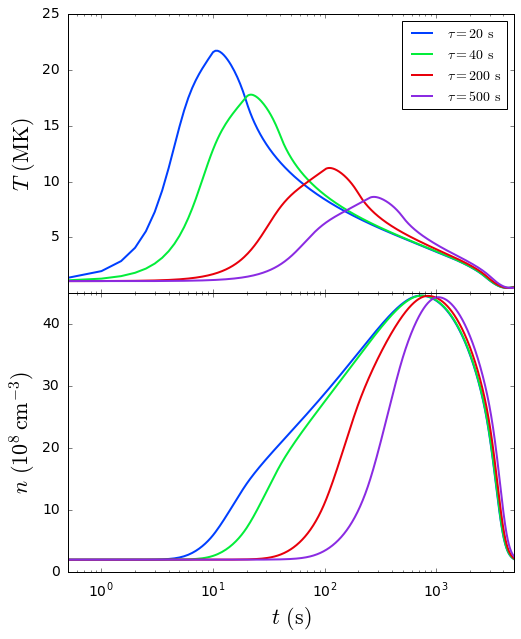

In [9]:
fig,ax = plt.subplots(2,1,figsize=(8,10),sharex=True)
plt.subplots_adjust(hspace=0.0)
#plotting
for i in range(len(tau_h_results)):
    ax[0].plot(tau_h_results[i]['t'],tau_h_results[i]['T']/1e+6,color=sns.color_palette('bright')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    ax[1].plot(tau_h_results[i]['t'],tau_h_results[i]['n']/1e+8,color=sns.color_palette('bright')[i],
               linestyle='solid')
#scale
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#limits
ax[0].set_xlim([0,5000])
ax[0].set_ylim([0,25])
ax[1].set_xlim([0,5000])
ax[1].set_ylim([0,45])
#tick labels
ax[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6,prune='lower'))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
ax[1].set_xlabel(r'$t$ $\mathrm{(s)}$')
ax[0].set_ylabel(r'$T$ $\mathrm{(MK)}$')
ax[1].set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
ax[0].legend()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/nT_tau_compare.pdf')
plt.show()

## Figure 2

Four-panel figure for $\tau=200,40$ s for electron heating and ion heating, showing $T_e,T_i,n$ for each case.

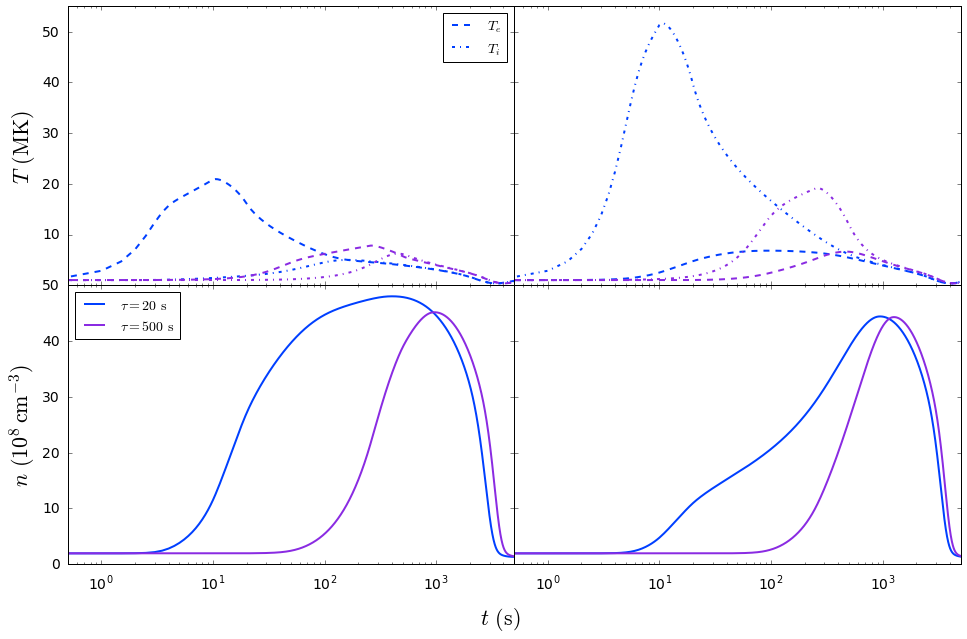

In [10]:
#set-up figure
fig,ax = plt.subplots(2,2,figsize=(16,10),sharex=True,)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
#place data
#northwest
ax[0,0].plot(tau_h_results[0]['te'],tau_h_results[0]['Tee']/1e+6,color=sns.color_palette('bright')[0],
             linestyle='dashed',label=r'$T_e$')
ax[0,0].plot(tau_h_results[0]['te'],tau_h_results[0]['Tei']/1e+6,color=sns.color_palette('bright')[0],
             linestyle='-.',label=r'$T_i$')
ax[0,0].plot(tau_h_results[-1]['te'],tau_h_results[-1]['Tee']/1e+6,color=sns.color_palette('bright')[3],
             linestyle='dashed')
ax[0,0].plot(tau_h_results[-1]['te'],tau_h_results[-1]['Tei']/1e+6,color=sns.color_palette('bright')[3],
             linestyle='-.')
#northeast
ax[0,1].plot(tau_h_results[0]['ti'],tau_h_results[0]['Tie']/1e+6,color=sns.color_palette('bright')[0],
             linestyle='dashed',label=r'$T_e$')
ax[0,1].plot(tau_h_results[0]['ti'],tau_h_results[0]['Tii']/1e+6,color=sns.color_palette('bright')[0],
             linestyle='-.',label=r'$T_i$')
ax[0,1].plot(tau_h_results[-1]['ti'],tau_h_results[-1]['Tie']/1e+6,color=sns.color_palette('bright')[3],
             linestyle='dashed')
ax[0,1].plot(tau_h_results[-1]['ti'],tau_h_results[-1]['Tii']/1e+6,color=sns.color_palette('bright')[3],
             linestyle='-.')
#southwest
ax[1,0].plot(tau_h_results[0]['te'],tau_h_results[0]['ne']/1e+8,color=sns.color_palette('bright')[0],
             linestyle='solid',label=r'$\tau=20$ $\mathrm{s}$')
ax[1,0].plot(tau_h_results[-1]['te'],tau_h_results[-1]['ne']/1e+8,color=sns.color_palette('bright')[3],
             linestyle='solid',label=r'$\tau=500$ $\mathrm{s}$' )
#southeast
ax[1,1].plot(tau_h_results[0]['ti'],tau_h_results[0]['ni']/1e+8,color=sns.color_palette('bright')[0],
             linestyle='solid')
ax[1,1].plot(tau_h_results[-1]['ti'],tau_h_results[-1]['ni']/1e+8,color=sns.color_palette('bright')[3],
             linestyle='solid')
#scale
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
#limits
ax[0,0].set_xlim([0,5000])
ax[0,1].set_xlim([0,5000])
ax[1,0].set_xlim([0,5000])
ax[1,1].set_xlim([0,5000])
ax[0,0].set_ylim([0,55])
ax[0,1].set_ylim([0,55])
ax[1,0].set_ylim([0,50])
ax[1,1].set_ylim([0,50])
#tick labels
#y-ticks
ax[0,1].axes.yaxis.set_ticklabels([])
ax[1,1].axes.yaxis.set_ticklabels([])
ax[0,0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6,prune='lower'))
ax[1,0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#x-ticks
#axes labels
fig.text(0.5, 0.05, r'$t$ $\mathrm{(s)}$', ha='center', va='center',fontsize=22)
ax[0,0].set_ylabel(r'$T$ $\mathrm{(MK)}$')
ax[1,0].set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
ax[0,0].legend(loc='best')
ax[1,0].legend(loc='best')
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/nT_tau_2fl_compare.pdf')
plt.show()

Look briefly at plot of electron pressure $p_e$ as a function of electron temperature, $T_e$.

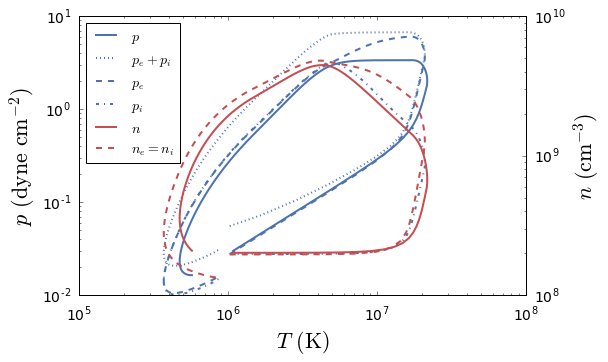

In [11]:
t_200 = tau_h_results[0]['te']
te_200 = tau_h_results[0]['Tee']
ne_200 = tau_h_results[0]['ne']
pe_200 = ac.k_B.cgs.value*tau_h_results[0]['ne']*tau_h_results[0]['Tee']
pi_200 = ac.k_B.cgs.value*tau_h_results[0]['ne']*tau_h_results[0]['Tei']
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
axn = ax.twinx()
line_ptot = ax.plot(te_200,pe_200+pi_200,label=r'$p_e+p_i$',color=sns.color_palette('deep')[0],linestyle=':')
line_pe = ax.plot(te_200,pe_200,linestyle='dashed',color=sns.color_palette('deep')[0],label=r'$p_e$')
line_pi = ax.plot(te_200,pi_200,linestyle='-.',color=sns.color_palette('deep')[0],label=r'$p_i$')
line_sf = ax.plot(tau_h_results[0]['T'],ac.k_B.cgs.value*tau_h_results[0]['n']*tau_h_results[0]['T'],
       color=sns.color_palette('deep')[0],label=r'$p$',linestyle='solid')
#axn.axvline(x=10**(7.3),linestyle='dotted',color='k')
#axn.axvline(x=10**(6.8),linestyle='dotted',color='k')
line_nsf = axn.plot(tau_h_results[0]['T'],tau_h_results[0]['n'],color=sns.color_palette('deep')[2],linestyle='solid',label=r'$n$')
line_n = axn.plot(te_200,ne_200,color=sns.color_palette('deep')[2],label=r'$n_e=n_i$',linestyle='dashed')
ax.set_yscale('log')
ax.set_xscale('log')
axn.set_yscale('log')
axn.set_xscale('log')
ax.set_xlabel(r'$T$ $\mathrm{(K)}$')
ax.set_ylabel(r'$p$ $(\mathrm{dyne}$ $\mathrm{cm}^{-2})$')
axn.set_ylabel(r'$n$ $(\mathrm{cm}^{-3})$')
lines = line_sf + line_ptot + line_pe + line_pi + line_nsf + line_n
labels = []
for l in lines:
    labels.append(l.get_label())
ax.legend(lines,labels,loc=2)
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/pnt_phase.pdf')

## Figure 3 + Figure 4
Emission measure distributions for range of heating options: $\tau,H_0,L$, and varying flux limiter.

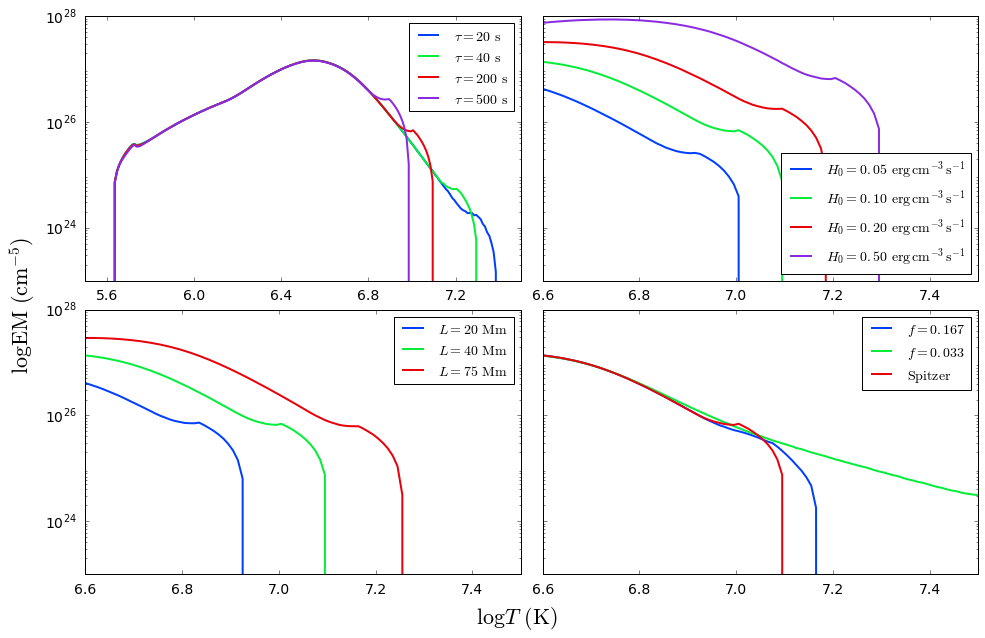

In [12]:
fig,ax = plt.subplots(2,2,figsize=(16,10),sharex=False,sharey=True)
plt.subplots_adjust(hspace=0.11,wspace=0.05)
#northwest--tau
for i in range(len(tau_h_results)):
    binner = emb.EM_Binner(tau_h_results[i]['t'],tau_h_results[i]['T'],tau_h_results[i]['n'],
                           2*config_dict['loop_length']*1e+8)
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
    ax[0,0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[i],linestyle='solid',
            label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
#northeast--h0
h0 = [.05,.1,.2,.5]
for i in range(len(h0)):
    results = run_and_print(config_dict,200.0,h0[i],40.0,1,'classical',runner)
    binner = emb.EM_Binner(results['t'],results['T'],results['n'],
                           2*config_dict['loop_length']*1e+8)
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
    ax[0,1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[i],linestyle='solid',
            label=r'$H_0=%.2f$ $\mathrm{erg}\,\mathrm{cm}^{-3}\,\mathrm{s}^{-1}$'%h0[i])
#southwest--L
loop_length = [20.0,40.0,75.0]
for i in range(len(loop_length)):
    results = run_and_print(config_dict,200.0,0.1,loop_length[i],1,'classical',runner)
    binner = emb.EM_Binner(results['t'],results['T'],results['n'],
                           2*loop_length[i]*1e+8)
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
    ax[1,0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[i],linestyle='solid',
            label=r'$L=%d$ $\mathrm{Mm}$'%loop_length[i])
#southeast--flux limiter
flux_lim = [[1.0/6.0,'limited'],[1.0/30.0,'limited'],[1.0,'classical']]
for i in range(len(flux_lim)):
    if flux_lim[i][1] == 'classical':
        plab = r'$\mathrm{Spitzer}$'
    else:
        plab = r'$f=%.3f$'%flux_lim[i][0]
    results = run_and_print(config_dict,200.0,0.1,40.0,flux_lim[i][0],flux_lim[i][1],runner)
    binner = emb.EM_Binner(results['t'],results['T'],results['n'],
                           2*config_dict['loop_length']*1e+8)
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
    ax[1,1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[i],linestyle='solid',
            label=plab)
#scale
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
#limits
ax[0,0].set_ylim([1e+23,1e+28])
ax[0,1].set_ylim([1e+23,1e+28])
ax[1,0].set_ylim([1e+23,1e+28])
ax[1,1].set_ylim([1e+23,1e+28])
ax[0,0].set_xlim([5.5,7.5])
ax[0,1].set_xlim([6.6,7.5])
ax[1,0].set_xlim([6.6,7.5])
ax[1,1].set_xlim([6.6,7.5])
#ticks
#x
ax[0,0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax[0,1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax[1,0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax[1,1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6,prune='lower'))
#y
ax[0,0].yaxis.set_major_locator(ticker.LogLocator(numticks=5))
#labels
fig.text(0.5, 0.065, r'$\log{T}$ $\mathrm{(K)}$', ha='center', va='center',fontsize=22)
fig.text(0.07, 0.5, r'$\log\mathrm{EM}$ $\mathrm{(cm}^{-5}\mathrm{)}$', ha='center',
         va='center', rotation='vertical',fontsize=22)
#legend
ax[0,0].legend(loc='best')
ax[0,1].legend(loc='best')
ax[1,0].legend(loc='best')
ax[1,1].legend(loc='best')
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/em_all_compare.pdf')
plt.show()

## Figure 5

Emission measure distribution comparing electron, ion, and single cases for both long (500 s) and short (20 s) pulses.

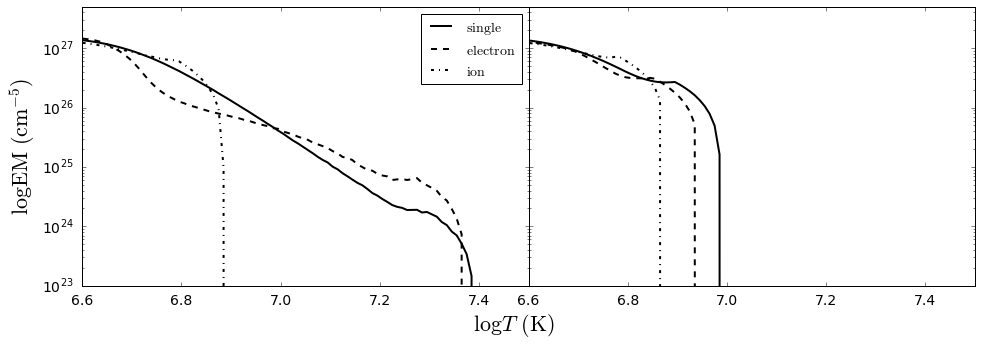

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,5),sharey=True)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
#short pulse
#single
binner = emb.EM_Binner(tau_h_results[0]['t'],tau_h_results[0]['T'],tau_h_results[0]['n'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='solid',
            label=r'$\mathrm{single}$')
tbin_single = (bin_edges[:-1]+bin_edges[1:])/2
em_single = np.log10(hist/10)
#electron
binner = emb.EM_Binner(tau_h_results[0]['te'],tau_h_results[0]['Tee'],tau_h_results[0]['ne'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='dashed',
            label=r'$\mathrm{electron}$')
tbin_electron = (bin_edges[:-1]+bin_edges[1:])/2
em_electron = np.log10(hist/10)
#ion
binner = emb.EM_Binner(tau_h_results[0]['ti'],tau_h_results[0]['Tie'],tau_h_results[0]['ni'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='-.',
            label=r'$\mathrm{ion}$')
#long pulse
#single
binner = emb.EM_Binner(tau_h_results[-1]['t'],tau_h_results[-1]['T'],tau_h_results[-1]['n'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='solid')
#electron
binner = emb.EM_Binner(tau_h_results[-1]['te'],tau_h_results[-1]['Tee'],tau_h_results[-1]['ne'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='dashed')
#ion
binner = emb.EM_Binner(tau_h_results[-1]['ti'],tau_h_results[-1]['Tie'],tau_h_results[-1]['ni'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='-.')
#scale
ax[0].set_yscale('log')
ax[1].set_yscale('log')
#limits
ax[0].set_xlim([6.6,7.5])
ax[0].set_ylim([1e+23,0.5e+28])
ax[1].set_xlim([6.6,7.5])
ax[1].set_ylim([1e+23,0.5e+28])
#labels
fig.text(0.5, 0.015, r'$\log{T}$ $\mathrm{(K)}$', ha='center', va='center',fontsize=22)
ax[0].set_ylabel(r'$\log\mathrm{EM}$ $\mathrm{(cm}^{-5}\mathrm{)}$')
#legend
ax[0].legend(loc='best')
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/em_tau_species_compare.pdf')

Do some fitting to see what the actual slopes are of theese emission measures.

In [14]:
#function to fit to
def linear_fit(x,a,b):
    return a*x + b

#find relevant temperature range
i_single = np.where((tbin_single>6.8) & (tbin_single<7.2))[0]
i_electron = np.where((tbin_electron>6.8) & (tbin_electron<7.2))[0]

#fitting
par_s,pc = curve_fit(linear_fit,tbin_single[i_single],em_single[i_single])
par_e,pc = curve_fit(linear_fit,tbin_electron[i_electron],em_electron[i_electron])

In [15]:
print(par_s[0])
print(par_e[0])

-5.33493399421
-2.9395181496


## Figure 6

Format the data to be run by `Ion_Pop_Solver` to compute $T_{eff}$.

In [16]:
#short pulse
#single
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6a.single.ips.txt'),
           np.transpose([tau_h_results[0]['t'],tau_h_results[0]['T'],tau_h_results[0]['n']]),
           header=str(len(tau_h_results[0]['t'])),comments='',fmt='%f\t%e\t%e')
#electron
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6a.electron.ips.txt'),
           np.transpose([tau_h_results[0]['te'],tau_h_results[0]['Tee'],tau_h_results[0]['ne']]),
           header=str(len(tau_h_results[0]['te'])),comments='',fmt='%f\t%e\t%e')
#ion
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6a.ion.ips.txt'),
           np.transpose([tau_h_results[0]['ti'],tau_h_results[0]['Tie'],tau_h_results[0]['ni']]),
           header=str(len(tau_h_results[0]['ti'])),comments='',fmt='%f\t%e\t%e')
#long pulse
#single
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6b.single.ips.txt'),
           np.transpose([tau_h_results[-1]['t'],tau_h_results[-1]['T'],tau_h_results[-1]['n']]),
           header=str(len(tau_h_results[-1]['t'])),comments='',fmt='%f\t%e\t%e')
#electron
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6b.electron.ips.txt'),
           np.transpose([tau_h_results[-1]['te'],tau_h_results[-1]['Tee'],tau_h_results[-1]['ne']]),
           header=str(len(tau_h_results[-1]['te'])),comments='',fmt='%f\t%e\t%e')
#ion
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6b.ion.ips.txt'),
           np.transpose([tau_h_results[-1]['ti'],tau_h_results[-1]['Tie'],tau_h_results[-1]['ni']]),
           header=str(len(tau_h_results[-1]['ti'])),comments='',fmt='%f\t%e\t%e')

Now run the `Ion_Pop_Solver` code! Then, plot the results.

In [17]:
#load variables
f6a_single = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6a.single.sol.ips.txt')
f6a_electron = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6a.electron.sol.ips.txt')
f6a_ion = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6a.ion.sol.ips.txt')
f6b_single = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6b.single.sol.ips.txt')
f6b_electron = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6b.electron.sol.ips.txt')
f6b_ion = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6b.ion.sol.ips.txt')

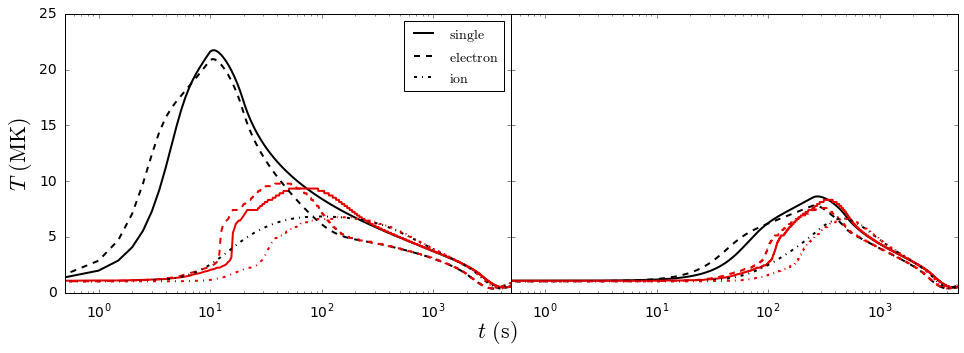

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,5),sharey=True)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
#plotting
#short
ax[0].plot(f6a_single[:,0],f6a_single[:,1]/1e+6,color=sns.xkcd_rgb['black'],linestyle='solid',
           label=r'$\mathrm{single}$')
ax[0].plot(f6a_single[:,0],f6a_single[:,2]/1e+6,color=sns.xkcd_rgb['red'],linestyle='solid')
ax[0].plot(f6a_electron[:,0],f6a_electron[:,1]/1e+6,color=sns.xkcd_rgb['black'],linestyle='dashed',
           label=r'$\mathrm{electron}$')
ax[0].plot(f6a_electron[:,0],f6a_electron[:,2]/1e+6,color=sns.xkcd_rgb['red'],linestyle='dashed')
ax[0].plot(f6a_ion[:,0],f6a_ion[:,1]/1e+6,color=sns.xkcd_rgb['black'],linestyle='-.',
           label=r'$\mathrm{ion}$')
ax[0].plot(f6a_ion[:,0],f6a_ion[:,2]/1e+6,color=sns.xkcd_rgb['red'],linestyle='-.')
#long
ax[1].plot(f6b_single[:,0],f6b_single[:,1]/1e+6,color=sns.xkcd_rgb['black'],linestyle='solid',
           label=r'$\mathrm{single}$')
ax[1].plot(f6b_single[:,0],f6b_single[:,2]/1e+6,color=sns.xkcd_rgb['red'],linestyle='solid')
ax[1].plot(f6b_electron[:,0],f6b_electron[:,1]/1e+6,color=sns.xkcd_rgb['black'],linestyle='dashed',
           label=r'$\mathrm{electron}$')
ax[1].plot(f6b_electron[:,0],f6b_electron[:,2]/1e+6,color=sns.xkcd_rgb['red'],linestyle='dashed')
ax[1].plot(f6b_ion[:,0],f6b_ion[:,1]/1e+6,color=sns.xkcd_rgb['black'],linestyle='-.',
           label=r'$\mathrm{ion}$')
ax[1].plot(f6b_ion[:,0],f6b_ion[:,2]/1e+6,color=sns.xkcd_rgb['red'],linestyle='-.')
#scale
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#limits
ax[0].set_xlim([0,5000])
ax[1].set_xlim([0,5000])
ax[0].set_ylim([0,25])
ax[1].set_ylim([0,25])
#tick labels
ax[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6,prune='lower'))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#axes labels
ax[0].set_ylabel(r'$T$ $\mathrm{(MK)}$')
fig.text(0.5, 0.015, r'$t$ $\mathrm{(s)}$', ha='center', va='center',fontsize=22)
#legend
ax[0].legend(loc='best')
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/nT_teff_compare.pdf')

## Figure 7

Emission measure distribution comparision between $T$ and $T_{eff}$ for some of the cases above. With this figure, Figure 5 becomes unnecessary.

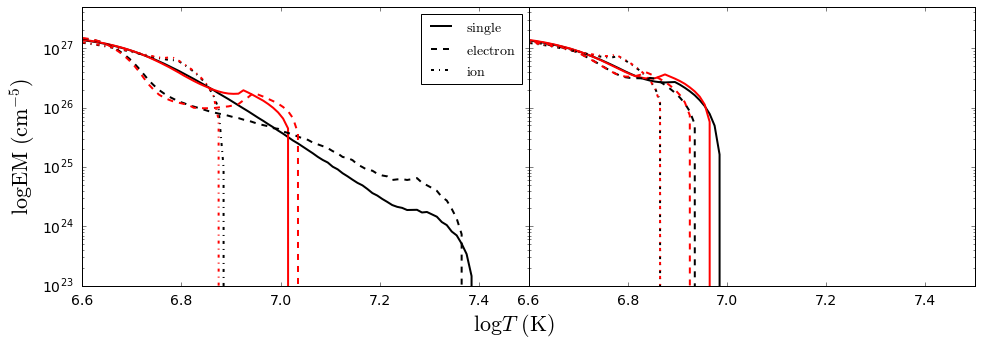

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,5),sharey=True)
plt.subplots_adjust(wspace=0.0,hspace=0.0)
#short
#single
binner = emb.EM_Binner(f6a_single[:,0],f6a_single[:,1],f6a_single[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='solid',
            label=r'$\mathrm{single}$')
binner = emb.EM_Binner(f6a_single[:,0],f6a_single[:,2],f6a_single[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='r',linestyle='solid')
#electron
binner = emb.EM_Binner(f6a_electron[:,0],f6a_electron[:,1],f6a_electron[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='dashed',
            label=r'$\mathrm{electron}$')
binner = emb.EM_Binner(f6a_electron[:,0],f6a_electron[:,2],f6a_electron[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='r',linestyle='dashed')
#ion
binner = emb.EM_Binner(f6a_ion[:,0],f6a_ion[:,1],f6a_ion[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='-.',
            label=r'$\mathrm{ion}$')
binner = emb.EM_Binner(f6a_ion[:,0],f6a_ion[:,2],f6a_ion[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='r',linestyle='-.')
#long
binner = emb.EM_Binner(f6b_single[:,0],f6b_single[:,1],f6b_single[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='solid',
            label=r'$\mathrm{single}$')
binner = emb.EM_Binner(f6b_single[:,0],f6b_single[:,2],f6b_single[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='r',linestyle='solid')
#electron
binner = emb.EM_Binner(f6b_electron[:,0],f6b_electron[:,1],f6b_electron[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='dashed',
            label=r'$\mathrm{electron}$')
binner = emb.EM_Binner(f6b_electron[:,0],f6b_electron[:,2],f6b_electron[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='r',linestyle='dashed')
#ion
binner = emb.EM_Binner(f6b_ion[:,0],f6b_ion[:,1],f6b_ion[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='-.',
            label=r'$\mathrm{ion}$')
binner = emb.EM_Binner(f6b_ion[:,0],f6b_ion[:,2],f6b_ion[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='r',linestyle='-.')
#scale
ax[0].set_yscale('log')
ax[1].set_yscale('log')
#limits
ax[0].set_xlim([6.6,7.5])
ax[0].set_ylim([1e+23,0.5e+28])
ax[1].set_xlim([6.6,7.5])
ax[1].set_ylim([1e+23,0.5e+28])
#labels
fig.text(0.5, 0.015, r'$\log{T}$ $\mathrm{(K)}$', ha='center', va='center',fontsize=22)
ax[0].set_ylabel(r'$\log\mathrm{EM}$ $\mathrm{(cm}^{-5}\mathrm{)}$')
#legend
ax[0].legend(loc='best')
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/em_teff_compare.pdf')

## HYDRAD Comparisons

Read in results from HYDRAD runs for $\tau=20,40,200,500$ s and compute the average of $n,T$ over the top 50% of the loop.

In [20]:
hfRes_format = '/home/ricesolarphyiscs/Documents/HYDRAD_v4_%s/Results/profile%d.phy'

In [21]:
def spatial_average(s,f,mp,eps_mp):
    #calculate bounds
    mp_lower = mp - eps_mp/2.0*mp
    mp_upper = mp + eps_mp/2.0*mp
    #find f and s within specified bounds
    i_eb = np.where((s>=mp_lower) & (s<=mp_upper))[0]
    s_eb = s[i_eb]
    f_eb = f[i_eb]
    #take average
    delta_s = np.gradient(s_eb)
    return 1.0/(np.sum(delta_s))*np.sum(f_eb*delta_s)

In [22]:
hydrad_time = np.arange(0,5001)
hydrad_res = {}
loop_midpoint = 4.5e+9
int_perc = 0.5

In [23]:
#tau=20 s run
Te_avg = []
Ti_avg = []
n_avg = []
for t in hydrad_time:
    #Load results
    temp = np.loadtxt(hfRes_format%('20s_faster',t))
    #slice
    s_temp = temp[:,0]
    Te_temp = temp[:,7]
    Ti_temp = temp[:,8]
    n_temp = temp[:,3]
    #save averages
    Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
    Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
    n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))
    
hydrad_res['tau20s'] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

In [24]:
#tau=40 s run
Te_avg = []
Ti_avg = []
n_avg = []
for t in hydrad_time:
    #Load results
    temp = np.loadtxt(hfRes_format%('40s_faster',t))
    #slice
    s_temp = temp[:,0]
    Te_temp = temp[:,7]
    Ti_temp = temp[:,8]
    n_temp = temp[:,3]
    #save averages
    Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
    Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
    n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))
    
hydrad_res['tau40s'] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

In [25]:
#tau=200 s run
Te_avg = []
Ti_avg = []
n_avg = []
for t in hydrad_time:
    #Load results
    temp = np.loadtxt(hfRes_format%('200s',t))
    #slice
    s_temp = temp[:,0]
    Te_temp = temp[:,7]
    Ti_temp = temp[:,8]
    n_temp = temp[:,3]
    #save averages
    Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
    Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
    n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))
    
hydrad_res['tau200s'] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

In [26]:
#tau=500 s run
Te_avg = []
Ti_avg = []
n_avg = []
for t in hydrad_time:
    #Load results
    temp = np.loadtxt(hfRes_format%('500s',t))
    #slice
    s_temp = temp[:,0]
    Te_temp = temp[:,7]
    Ti_temp = temp[:,8]
    n_temp = temp[:,3]
    #save averages
    Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
    Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
    n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))
    
hydrad_res['tau500s'] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

Now plot the results on top of the EBTEL results.

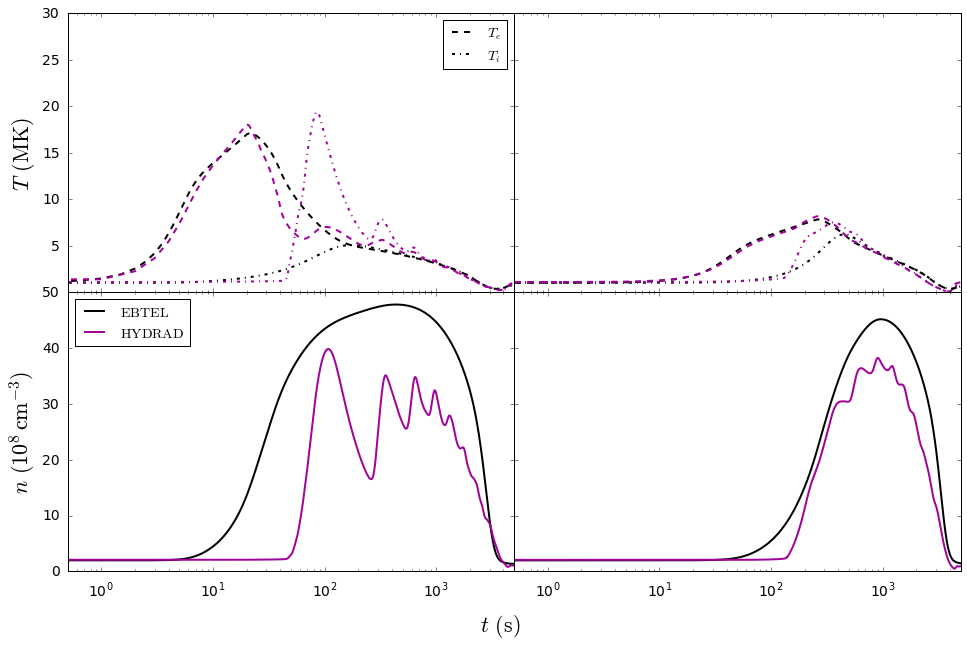

In [27]:
#set-up figure
fig,ax = plt.subplots(2,2,figsize=(16,10),sharex=True,)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
#place data
#northwest
ax[0,0].plot(tau_h_results[1]['te'],tau_h_results[1]['Tee']/1e+6,color='k',
             linestyle='dashed',label=r'$T_e$')
ax[0,0].plot(tau_h_results[1]['te'],tau_h_results[1]['Tei']/1e+6,color='k',
             linestyle='dashdot',label=r'$T_i$')
ax[0,0].plot(hydrad_time,np.array(hydrad_res['tau40s']['Te'])/1e+6,color=sns.xkcd_rgb['barney purple'],
             linestyle='dashed')
ax[0,0].plot(hydrad_time,np.array(hydrad_res['tau40s']['Ti'])/1e+6,color=sns.xkcd_rgb['barney purple'],
             linestyle='dashdot')

#northeast
ax[0,1].plot(tau_h_results[-1]['te'],tau_h_results[-1]['Tee']/1e+6,color='k',
             linestyle='dashed')
ax[0,1].plot(tau_h_results[-1]['te'],tau_h_results[-1]['Tei']/1e+6,color='k',
             linestyle='dashdot')
ax[0,1].plot(hydrad_time,np.array(hydrad_res['tau500s']['Te'])/1e+6,color=sns.xkcd_rgb['barney purple'],
             linestyle='dashed')
ax[0,1].plot(hydrad_time,np.array(hydrad_res['tau500s']['Ti'])/1e+6,color=sns.xkcd_rgb['barney purple'],
             linestyle='dashdot')
#southwest
ax[1,0].plot(tau_h_results[1]['te'],tau_h_results[1]['ne']/1e+8,color='k',
             linestyle='solid',label=r'$\mathrm{EBTEL}$')
ax[1,0].plot(hydrad_time,np.array(hydrad_res['tau40s']['n'])/1e+8,color=sns.xkcd_rgb['barney purple'],
             linestyle='solid',label=r'$\mathrm{HYDRAD}$' )
#southeast
ax[1,1].plot(tau_h_results[-1]['te'],tau_h_results[-1]['ne']/1e+8,color='k',
             linestyle='solid')
ax[1,1].plot(hydrad_time,np.array(hydrad_res['tau500s']['n'])/1e+8,color=sns.xkcd_rgb['barney purple'],
             linestyle='solid')
#scale
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
#limits
ax[0,0].set_xlim([0,5000])
ax[0,1].set_xlim([0,5000])
ax[1,0].set_xlim([0,5000])
ax[1,1].set_xlim([0,5000])
ax[0,0].set_ylim([0,30])
ax[0,1].set_ylim([0,30])
ax[1,0].set_ylim([0,50])
ax[1,1].set_ylim([0,50])
#tick labels
#y-ticks
ax[0,1].axes.yaxis.set_ticklabels([])
ax[1,1].axes.yaxis.set_ticklabels([])
ax[0,0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6,prune='lower'))
ax[1,0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#x-ticks
#axes labels
fig.text(0.5, 0.05, r'$t$ $\mathrm{(s)}$', ha='center', va='center',fontsize=22)
ax[0,0].set_ylabel(r'$T$ $\mathrm{(MK)}$')
ax[1,0].set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
ax[0,0].legend(loc='best')
ax[1,0].legend(loc='best')
#save
plt.show()

Compare the $\mathrm{EM}$ distributions for HYDRAD and EBTEL

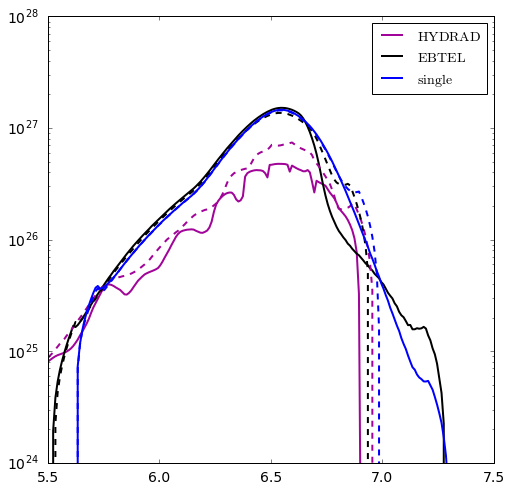

In [28]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
#tau20s
binner = emb.EM_Binner(hydrad_time,hydrad_res['tau40s']['Te'],hydrad_res['tau40s']['n'],8.0e+9)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.xkcd_rgb['barney purple'],
            label=r'$\mathrm{HYDRAD}$')
binner = emb.EM_Binner(tau_h_results[1]['te'],tau_h_results[1]['Tee'],tau_h_results[1]['ne'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',label=r'$\mathrm{EBTEL}$')
#tau200s
binner = emb.EM_Binner(hydrad_time,hydrad_res['tau500s']['Te'],hydrad_res['tau500s']['n'],8.0e+9)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.xkcd_rgb['barney purple'],
            linestyle='dashed')
binner = emb.EM_Binner(tau_h_results[-1]['te'],tau_h_results[-1]['Tee'],tau_h_results[-1]['ne'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='k',linestyle='dashed')
#single fluid
binner = emb.EM_Binner(tau_h_results[1]['t'],tau_h_results[1]['T'],tau_h_results[1]['n'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='b',linestyle='solid',
            label=r'$\mathrm{single}$')
binner = emb.EM_Binner(tau_h_results[-1]['t'],tau_h_results[-1]['T'],tau_h_results[-1]['n'],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='b',linestyle='dashed')
ax.set_yscale('log')
ax.set_ylim([1e+24,1e+28])
ax.set_xlim([5.5,7.5])
ax.legend()

Now, make HYDRAD plot using the four different pulse durations, similar to Fig. 1

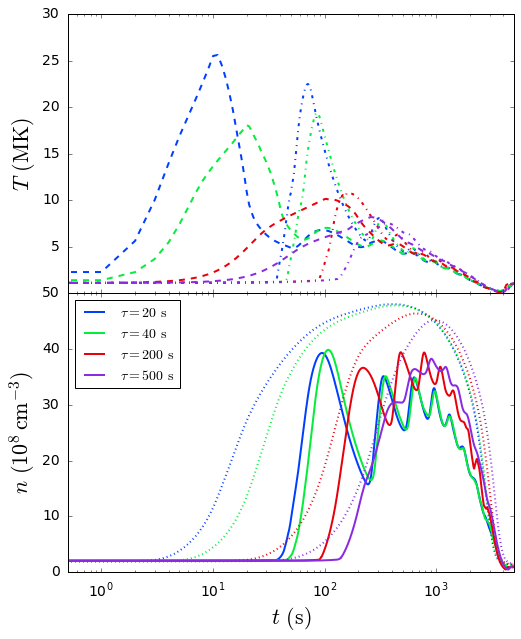

In [29]:
fig,ax = plt.subplots(2,1,figsize=(8,10),sharex=True)
plt.subplots_adjust(hspace=0.0)
#plotting
hr_tau = ['tau20s','tau40s','tau200s','tau500s']
i=0
for entry in hr_tau:
    ax[0].plot(hydrad_time,np.array(hydrad_res[entry]['Te'])/1e+6,color=sns.color_palette('bright')[i],
               linestyle='dashed')
    ax[0].plot(hydrad_time,np.array(hydrad_res[entry]['Ti'])/1e+6,color=sns.color_palette('bright')[i],
               linestyle='-.')
    ax[1].plot(hydrad_time,np.array(hydrad_res[entry]['n'])/1e+8,color=sns.color_palette('bright')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    ax[1].plot(tau_h_results[i]['te'],tau_h_results[i]['ne']/1e+8,color=sns.color_palette('bright')[i],linestyle=':')
    i+=1
    
#scale
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#limits
ax[0].set_xlim([0,5000])
ax[0].set_ylim([0,30])
ax[1].set_xlim([0,5000])
ax[1].set_ylim([0,50])
#tick labels
ax[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6,prune='lower'))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
ax[1].set_xlabel(r'$t$ $\mathrm{(s)}$')
ax[0].set_ylabel(r'$T$ $\mathrm{(MK)}$')
ax[1].set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
ax[1].legend(loc='best')
plt.show()

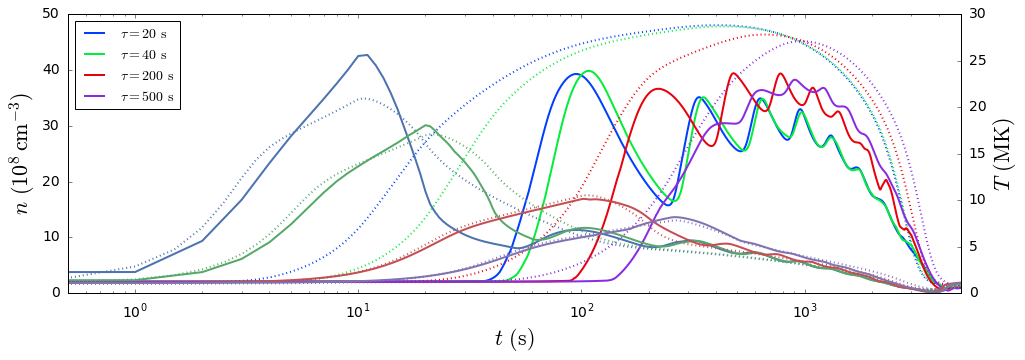

In [30]:
fig = plt.figure(figsize=(16,5))
ax  = fig.gca()
axT = ax.twinx()
i=0
for entry in hr_tau:
    #density
    ax.plot(hydrad_time,np.array(hydrad_res[entry]['n'])/1e+8,color=sns.color_palette('bright')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    ax.plot(tau_h_results[i]['te'],tau_h_results[i]['ne']/1e+8,color=sns.color_palette('bright')[i],linestyle=':')
    #temperature
    axT.plot(hydrad_time,np.array(hydrad_res[entry]['Te'])/1e+6,color=sns.color_palette('deep')[i],
               linestyle='solid')
    axT.plot(tau_h_results[i]['te'],tau_h_results[i]['Tee']/1e+6,color=sns.color_palette('deep')[i],
               linestyle=':')
    i+=1
    
#scale
ax.set_xscale('log')
axT.set_xscale('log')
#limits
ax.set_xlim([0,5000])
axT.set_xlim([0,5000])
ax.set_ylim([0,50])
#axes labels
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
axT.set_ylabel(r'$T$ $\mathrm{(MK)}$')
ax.set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
ax.legend(loc='best')
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/hydrad_compare.pdf')
plt.show()